In [109]:
#using direct sampling by random normal function, instead of MH for conditional distribution
#allow double zero at first

In [110]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [111]:
#from here on, direct sampling on w
def generate_std_mu_w(index,w,pi_l,pi_r,var_l,var_r,x_l,x_r,b,tau,beta,dim,p):
    ind_0_low,ind_0_high = int(index[0]-(np.sign(index[0]-0.99)+1)/2),int(index[0]+(np.sign((dim-1-0.01)-index[0])+1)/2)
    ind_1_low,ind_1_high = int(index[1]-(np.sign(index[1]-0.99)+1)/2),int(index[1]+(np.sign((dim-1-0.01)-index[1])+1)/2)
    no_nei = ind_0_high - ind_0_low + ind_1_high - ind_1_low
    sum_nei = np.sum(w[:,index[0],ind_1_low:ind_1_high+1],axis=1)-2*w[:,index[0],index[1]]+np.sum(w[:,ind_0_low:ind_0_high+1,index[1]],axis=1)
    std = (2*tau*((x_l[:,index[0],index[1]]-x_r[:,index[0],index[1]])**2+beta*no_nei+pi_l[:,index[0],index[1]]/2/var_l+pi_r[:,index[0],index[1]]/2/var_r))**-0.5
    mu = tau*((b[:,index[0],index[1]]-x_r[:,index[0],index[1]])*(x_l[:,index[0],index[1]]-x_r[:,index[0],index[1]])+(x_l[:,index[0],index[1]]-x_r[:,index[0],index[1]])**2/2/var_l*pi_l[:,index[0],index[1]]+beta*sum_nei)
    mu = mu/(0.5*std**-2)
    return mu,std

In [112]:
def p_pi_l_new(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xl = 1/(2*var)*pi_l[:,i,j]*(x_l[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_l[:,:,0].reshape(p,-1,1),pi_l,pi_l[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_l = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xl+E_pi_l))

In [113]:
def p_pi_r_new(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p):
    #sparse coefficient alpha TBC
    i,j = index[0],index[1]
    s_n = w[:,i,j]*x_l[:,i,j]+(1-w[:,i,j])*x_r[:,i,j]
    E_xr = 1/(2*var)*pi_r[:,i,j]*(x_r[:,i,j]-s_n)**2
    pi_extended = np.concatenate((pi_r[:,:,0].reshape(p,-1,1),pi_r,pi_r[:,:,-1].reshape(p,-1,1)),axis=2)
    pi_extended = np.concatenate((pi_extended[:,0,:].reshape(p,1,-1),pi_extended,pi_extended[:,-1,:].reshape(p,1,-1)),axis=1)
    #E_pi_l = alpha*(pi_extended[i+2,j+1]+pi_extended[i+1,j+2]+pi_extended[i,j+1]+pi_extended[i+1,j])
    '''E_pi_l = E_pi_l + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:i+1,j+1]-pi_extended[:,i+1,j])**2)'''
    E_pi_r = gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j])**2)
    E_pi_r = E_pi_r + gamma*((pi_extended[:,i+1,j+1]-pi_extended[:,i+2,j+1])**2+(pi_extended[:,i+1,j+1]-pi_extended[:,i+1,j+2])**2)
    return np.exp(-tau*(E_xr+E_pi_r))

In [114]:
def likelihood_ratio_pi_l(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p):
    #likelihood ratio: p(pi_l)=1/p(pi_l)=0
    pi_l_1 = pi_l.copy()
    pi_l_1[:,index[0],index[1]] = 1
    pi_l_0 = pi_l.copy()
    pi_l_0[:,index[0],index[1]] = 0
    return p_pi_l_new(index,w,x_l,x_r,pi_l_1,var,b,tau,gamma,p)/p_pi_l_new(index,w,x_l,x_r,pi_l_0,var,b,tau,gamma,p)

In [115]:
def likelihood_ratio_pi_r(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p):
    #likelihood ratio: p(pi_l)=1/p(pi_l)=0
    pi_r_1 = pi_r.copy()
    pi_r_1[:,index[0],index[1]] = 1
    pi_r_0 = pi_r.copy()
    pi_r_0[:,index[0],index[1]] = 0
    return p_pi_r_new(index,w,x_l,x_r,pi_r_1,var,b,tau,gamma,p)/p_pi_r_new(index,w,x_l,x_r,pi_r_0,var,b,tau,gamma,p)

In [116]:
def simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample):
    #p: no. parallel sampling sequences
    #no. sample: no. samples in each sequence
    #dim: dimension of each MRF
    sampling_order_i = np.arange(dim)
    sampling_order_j = np.arange(dim)

    #set initial condition for w, pi_r, pi_l
    #set visual input x_r, x_l as conflicting input
    x_l = np.ones((p,dim,dim))
    x_r = np.zeros((p,dim,dim))
    w = random.rand(p,dim,dim)
    pi_l = random.randint(0,2,(p,dim,dim))
    pi_r = random.randint(0,2,(p,dim,dim))

    s = []
    for m in range(int(no_sample)):
        #order of sweep is randomnized
        random.shuffle(sampling_order_i)
        random.shuffle(sampling_order_j)
        #the following for loop update on pi_l
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                ratio_l = likelihood_ratio_pi_l(index,w,x_l,x_r,pi_l,var,b,tau,gamma,p)
                pi_l[:,i,j] = (np.sign(ratio_l/(1+ratio_l)-random.random(p))+1)/2
                

        #the following for loop update on pi_r
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                ratio_r = likelihood_ratio_pi_r(index,w,x_l,x_r,pi_r,var,b,tau,gamma,p)
                pi_r[:,i,j] = (np.sign(ratio_r/(1+ratio_r)-random.random(p))+1)/2
    
        #the following for loop update on w
        for i in sampling_order_i:
            for j in sampling_order_j:
                index = (i,j)
                mu,std = generate_std_mu_w(index,w,pi_l,pi_r,var,var,x_l,x_r,b,tau,beta,dim,p)
                w[:,i,j] = random.normal(mu,std,p)
        
        s_i = w*x_l+(1-w)*x_r
        s.append(s_i)
    return np.array(s)

In [117]:
var,beta,gamma,alpha,tau,b,dim,p,no_sample = 0.0005,15,15,0,1/100,np.zeros((400,5,5)),5,400,44000
s = simulation_new(var,beta,gamma,alpha,tau,b,dim,p,no_sample)

Text(0.5, 0, 'percept')

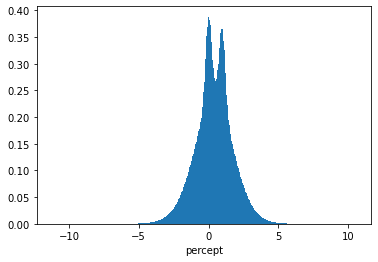

In [118]:
plt.hist(np.array(s).reshape(-1),500,density=True)
plt.xlabel('percept')

Text(0, 0.5, 'no. nodes > 0.5')

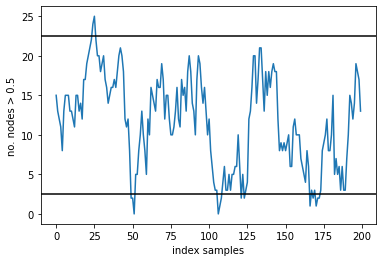

In [141]:
s = np.array(s)
plt.plot(np.array([len(np.where(state>0.5)[0]) for state in s[:,10,:,:]])[1800:2000])
plt.axhline(y=2.5,color = 'k')
plt.axhline(y=22.5,color = 'k')
plt.xlabel('index samples')
plt.ylabel('no. nodes > 0.5')

In [120]:
def domi_period_count(state_list_input,dim):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>2.5 and state_list_input[i]<2.5:
            cross_list.append((i,2))
        elif state_list_input[i-1]<22.5 and state_list_input[i]>22.5:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
    return domi_list

In [121]:
#from node's state to the no. node > 0 in each step
state_no_array = []
for i in range(p):
    state_no_array_i = []
    for j in range(no_sample):
        state_no_array_i.append(len(np.where(s[j,i,:,:]>0.5)[0]))
    state_no_array.append(state_no_array_i)
state_no_array = np.array(state_no_array)

In [122]:
domi_list = []
for state_list_i in state_no_array:
    domi_list = domi_list + domi_period_count(state_list_i,5)

In [123]:
print(len(domi_list))

108923


In [124]:
np.mean(domi_list)

160.69351743892474

[1.4473114  0.56997468 2.40325809]


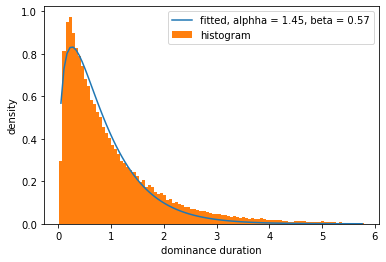

In [139]:
from scipy.optimize import curve_fit
domi_list=np.sort(np.array(domi_list))
y,bins=np.histogram(domi_list[:-500]/np.mean(domi_list[:-500]),100,density=True)
x = []
for i in range(1,101):
    x.append((bins[i]+bins[i-1])/2)
x=np.array(x)

def gamma(x,a,b,c):
    return c*np.exp(-b**-1*x)*x**(a-1)

popt,pcov = curve_fit(gamma,x,y)

plt.plot(x,gamma(x,popt[0],popt[1],popt[2]))
plt.hist(domi_list[:-500]/np.mean(domi_list[:-500]),100,density=True)

plt.xlabel('dominance duration')
plt.ylabel('density')
plt.legend(['fitted, alphha = 1.45, beta = 0.57','histogram'])

print(popt)